<a href="https://colab.research.google.com/github/SEA-uniovi/E_devices_TelecoUO/blob/pfmiaja-patch-1/PN_juntions_long.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PN junctions

In [1]:
import numpy as np
import matplotlib.pyplot as pt
from scipy import constants

from scipy.optimize import fsolve

import sympy as sp

#import the library
!git clone https://github.com/SEA-uniovi/E_devices_TelecoUO.git
#from google.colab import files

#files.os.chdir('libs')

# To find local version of the library
#sys.path.append(os.path.join(ROOT_DIR, 'libs'))




fatal: destination path 'E_devices_TelecoUO' already exists and is not an empty directory.


Function definitions

In [2]:
## Schokcley equations
def ipn_vj(Is,Vt,Vj):
    #Function to calculate the current through a PN junction (ipn) based on the voltage applied (Vj). Needs thermal voltage (Vt) and reverse saturation current (Is)
    exp_term=Vj/Vt
    ipn=Is*np.expm1(exp_term) #This gets e^x-1
    return ipn


def vj_ipn(Is,Vt,Ipn):
    #Function to calculate the voltage across a PN junction (vj) based on the current through it (ipn). Needs thermal voltage (Vt) and reverse saturation current (Is)
    log_term=Ipn/Is
    vj=Vt*np.log1p(log_term) #This gets log n + 1 the unvere of e^x-1 (expm1)
    return vj

def IV_resistance(Is,Vt,Ipn,Rn,Rp): #Function that gets the IV curve with bulk resistances in series injecting ipn
    vj=vj_ipn(Is,Vt,Ipn)
    vap=vj+Ipn*(Rn+Rp)
    return vap



# def solve_I(Is,Vt,Rn,Rp,Vap): #Function that solves the equation of a junction inseries with a resistance
#     res=Rn+Rp
#     Vap_vt=Vap/Vt
#     res_vt_is=Is*res/Vt
#     ids = sp.Symbol('ids')

#     f1 = sp.log(ids+1)+ids*res_vt_is-Vap_vt #function defined as the ratio beteen ipn and Is

#     iguess=ipn_vj(Is,Vt,Vap) #Initial guess the current through the PN juntcion with no drop in resistance
#     ids_guess=iguess/Is #initial guess needs to be provided as ipn/Is
#     ids_solution=sp.nsolve(f1,ids,ids_guess)
#     ipn=ids_solution*Is

#     return ipn




#Junction equations
def Lp(Dp,taup): #Difussion lenght on P zone needs Dp diffusion constant of holes and half life of holes taup in seconds in cm
    lenght_p=np.sqrt(Dp*taup)
    return lenght_p

def Ln(Dn,taun): #Difussion lenght on N zone needs Dn diffusion constant of e- and half life of e- taun
    lenght_n=np.sqrt(Dn*taun)
    return lenght_n

def Vt(T): #Thermal voltage as a function of Temperature T in Kelvin,
    vt=constants.k*T/constants.elementary_charge
    return vt

def vo (NA,ND,ni,vt): #Built in voltage needs Acceptor and Donor concentration (atoms/cm^2) and intrinsic carrier concentration () , need also thermal voltage
    log_term=NA*ND/ni**2
    vo=vt*np.log(log_term)
    return vo


def Vbr (Ebr,epsilon_rel,NA,ND,v_builtin): #Voltage breakdown need critical electric field Ebr V/m, Acceptor and Donor concentration atoms/cm3, electrical realtive permitivity epsilo_r and builtin_voltage v_builtin Volts
    epsilon_mat=epsilon_rel*constants.epsilon_0/100
    NA_ND=NA+ND
    Vbr_num=NA_ND*Ebr**2*epsilon_mat
    Vbr_den=2*NA*ND*constants.elementary_charge
    Vbr=Vbr_num/Vbr_den-v_builtin


    return Vbr

def Isat(section,NA,ND,ni,Dp,Lp,Dn,Ln): #reverse saturation current in A. section in cm^2
    doping_term_p=Dp/(ND*Lp)
    doping_term_n=Dn/(NA*Ln)
    doping_term=doping_term_p+doping_term_n
    Is=section*ni**2*constants.elementary_charge*doping_term
    return Is



def Jsat(NA,ND,ni,Dp,Lp,Dn,Ln): #reverse saturation current in A. section in cm^2
    doping_term_p=Dp/(ND*Lp)
    doping_term_n=Dn/(NA*Ln)
    doping_term=doping_term_p+doping_term_n
    Is=ni**2*constants.elementary_charge*doping_term
    return Is

def Ldepletion (NA,ND,Vd,vo,epsilon_rel): #Depletion zone length in cm gives also the depl lenght in P and N zones
    epsilon_mat=epsilon_rel*constants.epsilon_0/100
    NA_ND=NA+ND
    vapplied=vo-Vd
    w_squared=epsilon_mat*2*NA_ND*vapplied/(NA*ND*constants.elementary_charge)
    w=np.sqrt(w_squared)
    w_P=w*ND/NA_ND
    w_N=w*NA/NA_ND
    return w,w_N,w_P

def Cj(NA,ND,Vd,vo,epsilon_rel,section): #Depletion zone capacitance in F
    epsilon_mat=epsilon_rel*constants.epsilon_0/100
    NA_ND=NA+ND
    vapplied=vo-Vd
    cj_squared=epsilon_mat*(NA*ND*constants.elementary_charge)/(2*NA_ND*vapplied)
    cj=np.sqrt(cj_squared)*section
    return cj

def BulkResistance (N_i,mu_i,section,length): #Resistance in ohm of a neutral zone, N_i impurity (Donor/Acceptor) concentration in atoms/cm^3, mu_i mobility in cm2/(V*s)
    sigma=constants.elementary_charge*N_i*mu_i
    Res_ratio=length/section
    Res=Res_ratio/sigma
    return Res

def minorities_concentration_equilibrium(N_i,ni): #Minorities concentration in equilibrium needs _i impurity (Donor/Acceptor) concentration in atoms/cm^3, ni intrinsic carriedr concentration in carriesrs/cm^3
    minorities=ni**2/N_i
    return minorities

def excess_minorities(eq_minorities,vapplied,Vt): #Excess of minorities in border of depletion region needs equilibrium concentration in atoms/cm^2 and applied voltage V and thermal voltage Vt
    exp_term=vapplied/Vt
    excess_equation=eq_minorities*np.expm1(exp_term) #This gets e^x-1
    #If negative must be bigger or equal than eq_minorities so it does not go below 0
    excess=max(excess_equation,-1*eq_minorities)
    return excess

def current_minorities_border_long(excess_minorities,diff_length,Diff_const): #Current at the depletion region for a long Junction, needs excess of minorities and diffusion lenght of minorities

    doping_term=Diff_const/diff_length
    current_border=constants.elementary_charge*doping_term*excess_minorities

    return current_border

def Fermi_level_doped_deviation(N_i,ni,T): #Fermi Level for a doped semiconductor needs impurity (Donor/Acceptor) concentration in atoms/cm^3 and T temperature
    kT=constants.k*T
    log_term=N_i/ni
    deviation=kT*np.log(log_term)

    return deviation


#Plotting functions

def plot_concentration_carriers(NA,ND,ni,T,V,eps_rel,DnP,tau_nP,DpN,tau_pN): #Function to plot the concentration of thhe free carriers NA acceptor concentration, ND dibir concnetration, ni intrinsic carrier T  temperature, Vd voltage applied externally, relative electrical permitivity, DnP Difussivity length of e- in P zone, tau half life, DpN diffusivity of h in N zone tau half life
     LnP=np.sqrt(DnP*tau_nP) #Diffussion lenthg
     LpN=np.sqrt(DpN*tau_pN)


     vt=Vt(T) #Thermal voltage

     Vo=vo(NA,ND,ni,vt) #Built in voltage

     Ldep,LdepN,LdepP=Ldepletion(NA,ND,V,Vo,eps_rel) #Lengths of the depletion region

     LengthN=50*LpN #Define the N region as 10 times the diffusion length
     LengthP=50*LnP #Define the P region as 10 times the diffusion length

     n_points=10000
     xN=np.linspace(0,LengthN,n_points)
     xP=np.linspace(0,LengthP,n_points) #Support vectors for the X coordinate

     xNr=np.linspace(LdepN*10,(LdepN+LengthN)*10,n_points)
     xPr=np.linspace(LdepP*10,(LengthP+LdepP)*10,n_points) #Fore representation



     #Equilibirum minority concentration
     nP0=minorities_concentration_equilibrium(NA,ni) #electrons in P zone
     pN0=minorities_concentration_equilibrium(ND,ni)

     #Excess at the border
     delta_nP0=excess_minorities(nP0,V,vt)
     delta_pN0=excess_minorities(pN0,V,vt)

     #Evolution with position
     delta_nP=delta_nP0*np.exp(-xP/LnP)
     delta_pN=delta_pN0*np.exp(-xN/LpN)

     #Total number of minorities
     nP=nP0+delta_nP
     pN=pN0+delta_pN

     #Plotting it
     pt.figure(figsize=(15,9))
     pt.rcParams['text.usetex'] = False
     pt.rcParams.update({'font.size': 14})



     pt.semilogy(xNr,pN,color='blue') #Minorities concentration
     pt.hlines(pN0,min(xNr),max(xNr),color='blue',linestyle='dashed') #Minority concentration equilibrium
     pt.hlines(ND,min(xNr),max(xNr),color='red') #Majority concentration
     pt.axvline(LdepN*10,color="black",linestyle='dotted')


     pt.semilogy(-xPr,nP,color='red') #Minorities concentration
     pt.hlines(nP0,min(-xPr),max(-xPr),color='red',linestyle='dashed') #Minority concentration equilibrium
     pt.hlines(NA,min(-xPr),max(-xPr),color='blue') #Majority concentration
     pt.axvline(-LdepP*10,color="black",linestyle='dotted')

     #Annotations to identify the figures

     pt.annotate('P side',
            xy=(.25, .975), xycoords='figure fraction',
            horizontalalignment='left', verticalalignment='top',
            fontsize=20)

     pt.annotate('N side',
            xy=(.75, .975), xycoords='figure fraction',
            horizontalalignment='left', verticalalignment='top',
            fontsize=20)

     pt.annotate('pN',xy=(1.01*max(xNr), 4*pN0), xycoords='data')
     pt.annotate('nP',xy=(1.01*min(-xPr), 4*nP0), xycoords='data')
    #Majorities
     pt.annotate('1e'+str(np.round(np.log10(ND))),xy=(1.01*max(xNr), ND), xycoords='data',bbox=dict(boxstyle="round,pad=0.3", fc="lightblue", ec="steelblue", lw=2))
     pt.annotate('1e'+str(np.round(np.log10(NA))),xy=(1.01*min(-xPr), NA), xycoords='data',bbox=dict(boxstyle="round,pad=0.3",fc="lightblue", ec="steelblue", lw=2))
         #Minorities
    #Annotate values at limits
     pt.annotate('1e'+str(np.round(np.log10(pN0))),xy=(1.01*max(xNr), pN0), xycoords='data',bbox=dict(boxstyle="round,pad=0.3", fc="lightblue", ec="steelblue", lw=2))
     pt.annotate('1e'+str(np.round(np.log10(nP0))),xy=(1.01*min(-xPr), nP0), xycoords='data',bbox=dict(boxstyle="round,pad=0.3",fc="lightblue", ec="steelblue", lw=2))
     #Annotate values at dep border
     pt.annotate('1e'+str(np.round(np.log10(pN0+delta_pN0))),xy=(LdepN, pN0+delta_pN0),xytext=(LdepN*10+100*LpN, pN0+delta_pN0), xycoords='data',arrowprops=dict(facecolor='black', shrink=0.05, width=1),bbox=dict(boxstyle="round,pad=0.3", fc="lightblue", ec="steelblue", lw=2))
     pt.annotate('1e'+str(np.round(np.log10(nP0+delta_nP0))),xy=(-LdepP, nP0+delta_nP0),xytext=(-LdepP*10-100*LnP, nP0+delta_nP0), xycoords='data', arrowprops=dict(facecolor='black', shrink=0.05, width=1),bbox=dict(boxstyle="round,pad=0.3",fc="lightblue", ec="steelblue", lw=2))


     pt.annotate('nN',xy=(1.01*max(xNr), ND/4), xycoords='data')
     pt.annotate('pP',xy=(1.01*min(-xPr),NA/4), xycoords='data')

     pt.grid(axis='y', color='black',linestyle="dashed", which="both")
     pt.xlabel('Position (mm)')
     pt.ylabel('Carrier concentration ')




     return


def plot_currents(NA,ND,ni,T,V,eps_rel,DnP,tau_nP,DpN,tau_pN): #Function to plot the concentration of thhe free carriers NA acceptor concentration, ND dibir concnetration, ni intrinsic carrier T  temperature, Vd voltage applied externally, relative electrical permitivity, DnP Difussivity length of e- in P zone, tau half life, DpN diffusivity of h in N zone tau half life
     LnP=np.sqrt(DnP*tau_nP) #Diffussion lenthg
     LpN=np.sqrt(DpN*tau_pN)

     vt=Vt(T) #Thermal voltage

     Vo=vo(NA,ND,ni,vt) #Built in voltage

     Ldep,LdepN,LdepP=Ldepletion(NA,ND,V,Vo,eps_rel) #Lengths of the depletion region

     LengthN=10*LpN #Define the N region as 10 times the diffusion length
     LengthP=10*LnP #Define the P region as 10 times the diffusion length

     n_points=10000
     xN=np.linspace(0,LengthN,n_points)
     xP=np.linspace(0,LengthP,n_points) #Support vectors for the X coordinate

     xNr=np.linspace(LdepN*10,(LdepN+LengthN)*10,n_points)
     xPr=np.linspace(LdepP*10,(LengthP+LdepP)*10,n_points) #Fore representation



     #Equilibirum minority concentration
     nP0=minorities_concentration_equilibrium(NA,ni) #electrons in P zone
     pN0=minorities_concentration_equilibrium(ND,ni)

     #Excess at the border
     delta_nP0=excess_minorities(nP0,V,vt)
     delta_pN0=excess_minorities(pN0,V,vt)



     #Current
     Jp_Nb=delta_pN0/LpN*constants.elementary_charge*DpN #At border of depletion zone
     Jn_Pb=delta_nP0/LnP*constants.elementary_charge*DnP #At border of depletion zone
     J=Jp_Nb+Jn_Pb #Total constant current

      #Evolution with position
     Jp_N=Jp_Nb*np.exp(-xP/LnP) #Decaying minority current
     Jn_P=Jn_Pb*np.exp(-xN/LpN)

     J_N=J*np.ones_like(xN) #Constant current
     J_P=J*np.ones_like(xP)

     Jn_N=J_N-Jp_N
     Jp_P=J_P-Jn_P






     #Plotting it
     pt.figure(figsize=(10,6))
     pt.rcParams['text.usetex'] = False
     pt.rcParams.update({'font.size': 14})



     pt.plot(xNr,Jp_N,color='blue') #Minorities current density
     pt.hlines(Jp_Nb,-LdepP*10,LdepN*10,color='blue') #In the depletion region
     pt.plot(xNr,Jn_N,color='red') #Majorities current density


     pt.axvline(LdepN*10,color="black",linestyle='dotted')


     pt.plot(-xPr,Jn_P,color='red') #Minorities current density
     pt.plot(-xPr,Jp_P,color='blue') #Majorities current density
     pt.hlines(Jn_Pb,-LdepP*10,LdepN*10,color='red') #In the depletion region


     pt.axvline(-LdepP*10,color="black",linestyle='dotted')

     pt.hlines(J,min(-xPr),max(xNr),color="orange")

     #Annotations to identify the figures
     pt.annotate('P side',xy=(.25, .975), xycoords='figure fraction',horizontalalignment='left', verticalalignment='top',fontsize=20)

     pt.annotate('N side',xy=(.75, .975), xycoords='figure fraction',horizontalalignment='left', verticalalignment='top',fontsize=20)

     pt.annotate('JpN',xy=(1.01*max(xNr), 1.1*min(Jp_N)), xycoords='data')
     pt.annotate('JnP',xy=(1.01*min(-xPr), 1.1*min(Jn_P)), xycoords='data')

     pt.annotate('JnN',xy=(1.01*max(xNr), 1.01*J), xycoords='data')
     pt.annotate('JpP',xy=(1.01*min(-xPr),1.01*J), xycoords='data')

     #Annotate total current

     pt.annotate('J='+str(J),xy=(0, J),xytext=(1.01*max(xNr), 0.9*J), xycoords='data', arrowprops=dict(facecolor='black', shrink=0.05, width=1),bbox=dict(boxstyle="round,pad=0.3",fc="lightblue", ec="steelblue", lw=2))
     pt.annotate('Jp_Nb='+str(Jp_Nb),xy=(0, Jp_Nb),xytext=(1.01*max(xNr), 0.8*Jp_Nb), xycoords='data', arrowprops=dict(facecolor='black', shrink=0.05, width=1),bbox=dict(boxstyle="round,pad=0.3",fc="lightblue", ec="steelblue", lw=2))
     pt.annotate('Jn_Pb='+str(Jn_Pb),xy=(0, Jn_Pb),xytext=(1.01*max(xNr), 0.8*Jn_Pb), xycoords='data', arrowprops=dict(facecolor='black', shrink=0.05, width=1),bbox=dict(boxstyle="round,pad=0.3",fc="lightblue", ec="steelblue", lw=2))
     pt.xlabel('Position (mm)')
     pt.ylabel('Current density A/cm^2 ')




     return



## Define the material

### Semiconductor constants

In [3]:
ni=1e11 #e-/cm3
ebr=3e5 #V/cm
epsilon_rel=12
Dp=10 #Difussivity of holes cm2/s
Dn = 100 #Difussivity of e- cm2/s



### Junction design

In [4]:
Na=1e16 #Atoms/cm3
Nd=1e14 #Atoms/cm3
tau_p=100e-9 #s
tau_n=100e-9 #s
length_P=0.1 #cm
length_N=0.1 #cm
section=1 #cm^2
Temp=300 #Kelvin



If diffusion is fixed then mobility set by thermal voltage

In [5]:
Vthermal=Vt(Temp)
mu_p=Dp/Vthermal #Mobility of holes cm2/(V*s)
mu_n=Dn/Vthermal #Mobility of electrons cm2/(V*s)
print(Vthermal)
print(mu_p)
print(mu_n)

0.025851999786435535
386.81727071833603
3868.17270718336


## Results

### Static characteristics

In [6]:
Vo=vo(Na,Nd,ni,Vthermal)
Vo

0.4762114346586538

In [7]:
Vbreakdown=Vbr(ebr,epsilon_rel,Na,Nd,Vo)
Vbreakdown


3013.5947284496892

In [8]:
Is=Isat(section,Na,Nd,ni,Dp,Lp(Dp,tau_p),Dn,Ln(Dp,tau_n))
Is

1.7623942974e-07

### Concentration

In [10]:
Vtest=10*Vthermal
print(Vtest)

0.25851999786435537


In [12]:
Ldep,LdepN,LdepP=Ldepletion(Na,Nd,Vtest,Vo,epsilon_rel)
print(Ldep)
print(LdepP)
print(LdepN)

0.00017076786498419622
1.6907709404375863e-06
0.00016907709404375863


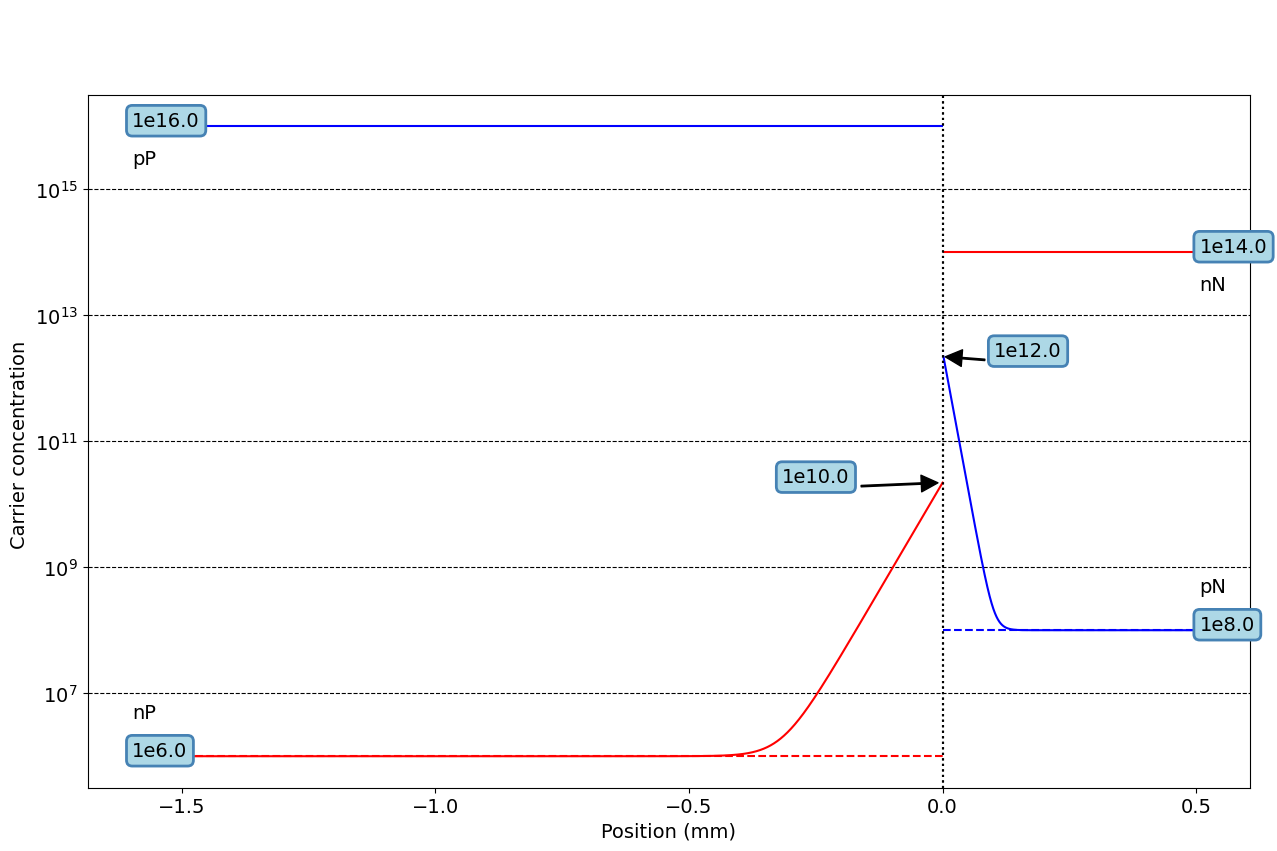

In [13]:
plot_concentration_carriers(Na,Nd,ni,Temp,Vtest,epsilon_rel,Dn,tau_n,Dp,tau_p)

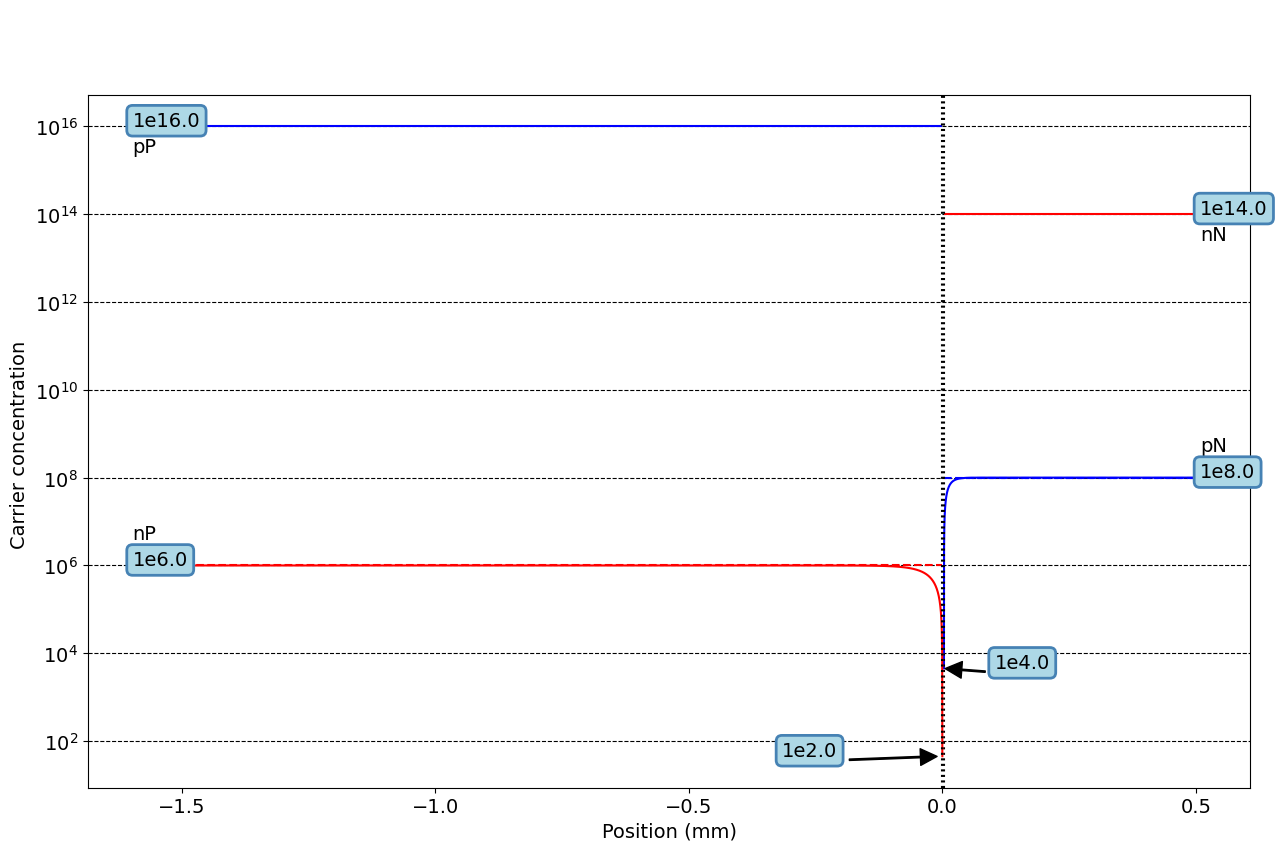

In [14]:
plot_concentration_carriers(Na,Nd,ni,Temp,-Vtest,epsilon_rel,Dn,tau_n,Dp,tau_p)

### Currents

In [15]:
I_forward_test=ipn_vj(Is,Vt(Temp),Vtest)
I_reverse_test=ipn_vj(Is,Vt(Temp),-Vtest)
print(I_forward_test)
print(I_reverse_test)

0.0038817555314346118
-1.7623142848226843e-07


In [16]:
Lp=Lp(Dp,tau_p)
Ln=Ln(Dn,tau_n)
print(Lp)
print(Ln)

0.001
0.0031622776601683794


In [17]:
(1e10-1e6)>(1e12-1e8)

False

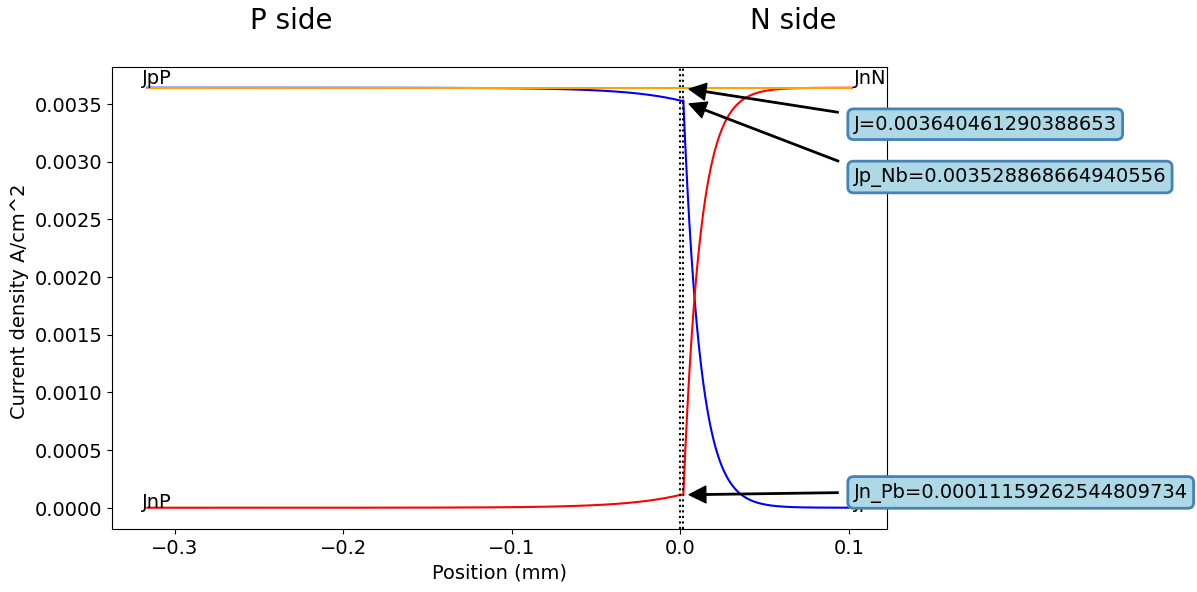

In [18]:
plot_currents(Na,Nd,ni,Temp,Vtest,epsilon_rel,Dn,tau_n,Dp,tau_p)

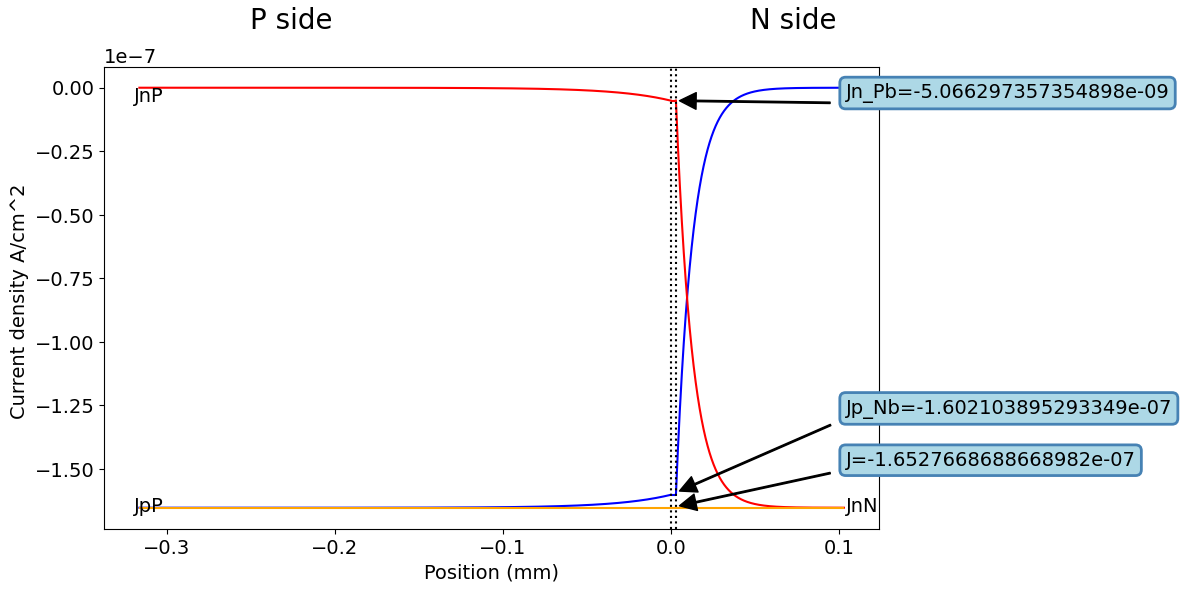

In [19]:
plot_currents(Na,Nd,ni,Temp,-Vtest,epsilon_rel,Dn,tau_n,Dp,tau_p)

### IV curve

0.0038817555314346118


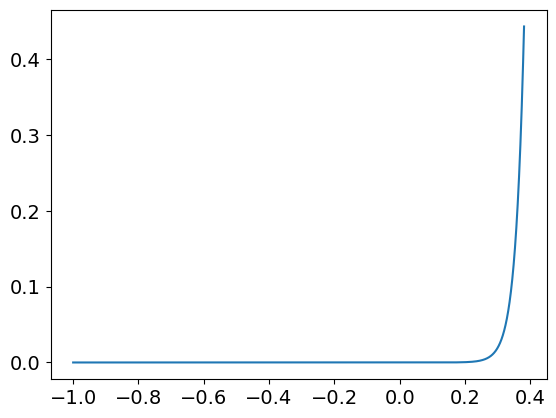

In [20]:
v_range=np.linspace(-1,Vo*0.8,10000)
v_test=np.array([-10,0.4])
print(ipn_vj(Is,Vt(Temp),Vtest))
pt.plot(v_range,ipn_vj(Is,Vt(Temp),v_range))

### Cj curve

[5.75144641e-10 2.38929744e-09]


<ipython-input-2-4a49852e6214>:99: RuntimeWarning: divide by zero encountered in divide
  cj_squared=epsilon_mat*(NA*ND*constants.elementary_charge)/(2*NA_ND*vapplied)


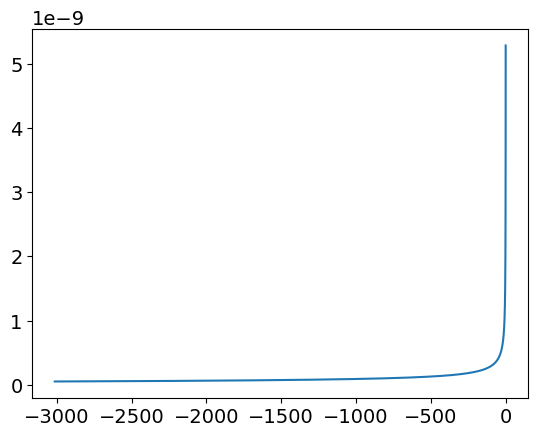

In [21]:
v_range=np.linspace(-Vbreakdown,Vo,10000)
v_test=np.array([-25,-1])
print(Cj(Na,Nd,v_test,Vo,epsilon_rel,section))
pt.plot(v_range,Cj(Na,Nd,v_range,Vo,epsilon_rel,section))

### Depletion zone length

[0.00118464 0.00030097 0.00019236]


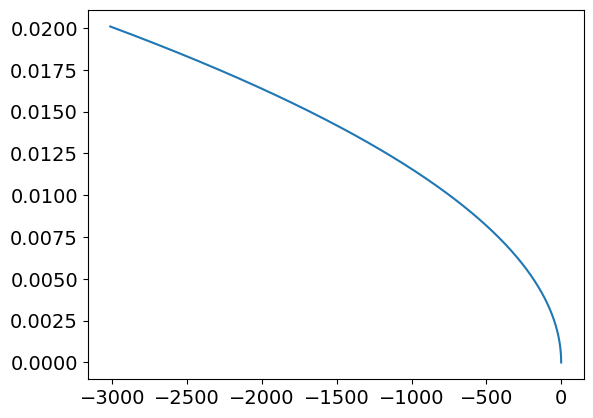

In [22]:
v_range=np.linspace(-Vbreakdown,Vo,10000)
v_test=np.array([-10,-0.2,0.2])
Ldep,LdepP,LdepN=Ldepletion(Na,Nd,v_test,Vo,epsilon_rel)
print(Ldep)
Ldep,LdepP,LdepN=Ldepletion(Na,Nd,v_range,Vo,epsilon_rel)
pt.plot(v_range,Ldep)